# Sport Classification

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

# GPU set up
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Input, MaxPooling2D, Dropout, GlobalMaxPooling2D

from sklearn.metrics import confusion_matrix, classification_report

In [21]:
target_size = (128, 128)
batch_size = 32

data_gen_aug = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
                                 shear_range=0.1, zoom_range=0.4, vertical_flip=True, horizontal_flip=True)
data_gen = ImageDataGenerator()
train_data = data_gen_aug.flow_from_directory('Data/train', target_size=target_size, batch_size=batch_size, 
                                         class_mode='categorical')

valid_data = data_gen.flow_from_directory('Data/valid', target_size=target_size, batch_size=batch_size,
                                         class_mode='categorical')

class_indices = train_data.class_indices
indicies_class = list(class_indices.keys())
num_classes = len(class_indices)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [5]:
freq = [0 for _ in range(num_classes)]

cnt = 0
for x, y in train_data:
    if cnt >= train_data.n: break
    for b in np.argmax(y, axis=-1):
        print(f'\r%{cnt * 100 / train_data.n : .2f}', end='')
        freq[b] += 1
        cnt += 1

% 99.99

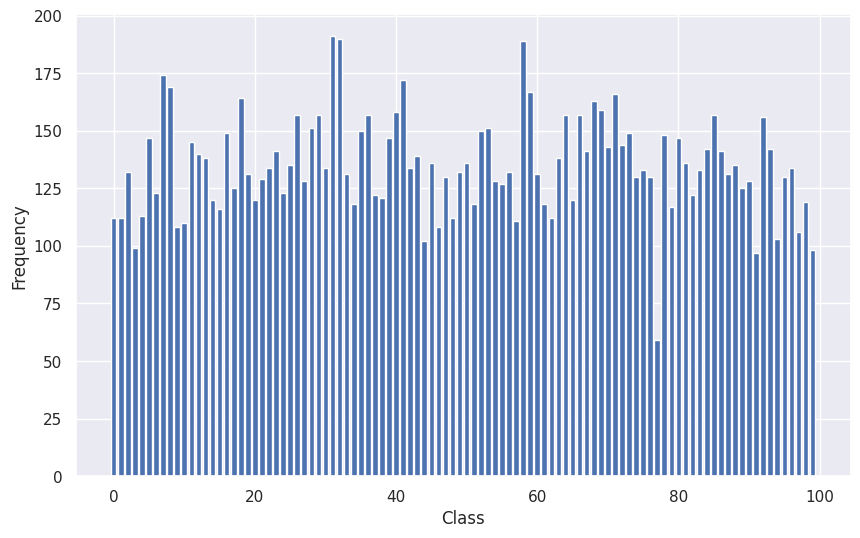

In [6]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.bar(range(100), freq);
plt.xlabel('Class');
plt.ylabel('Frequency');

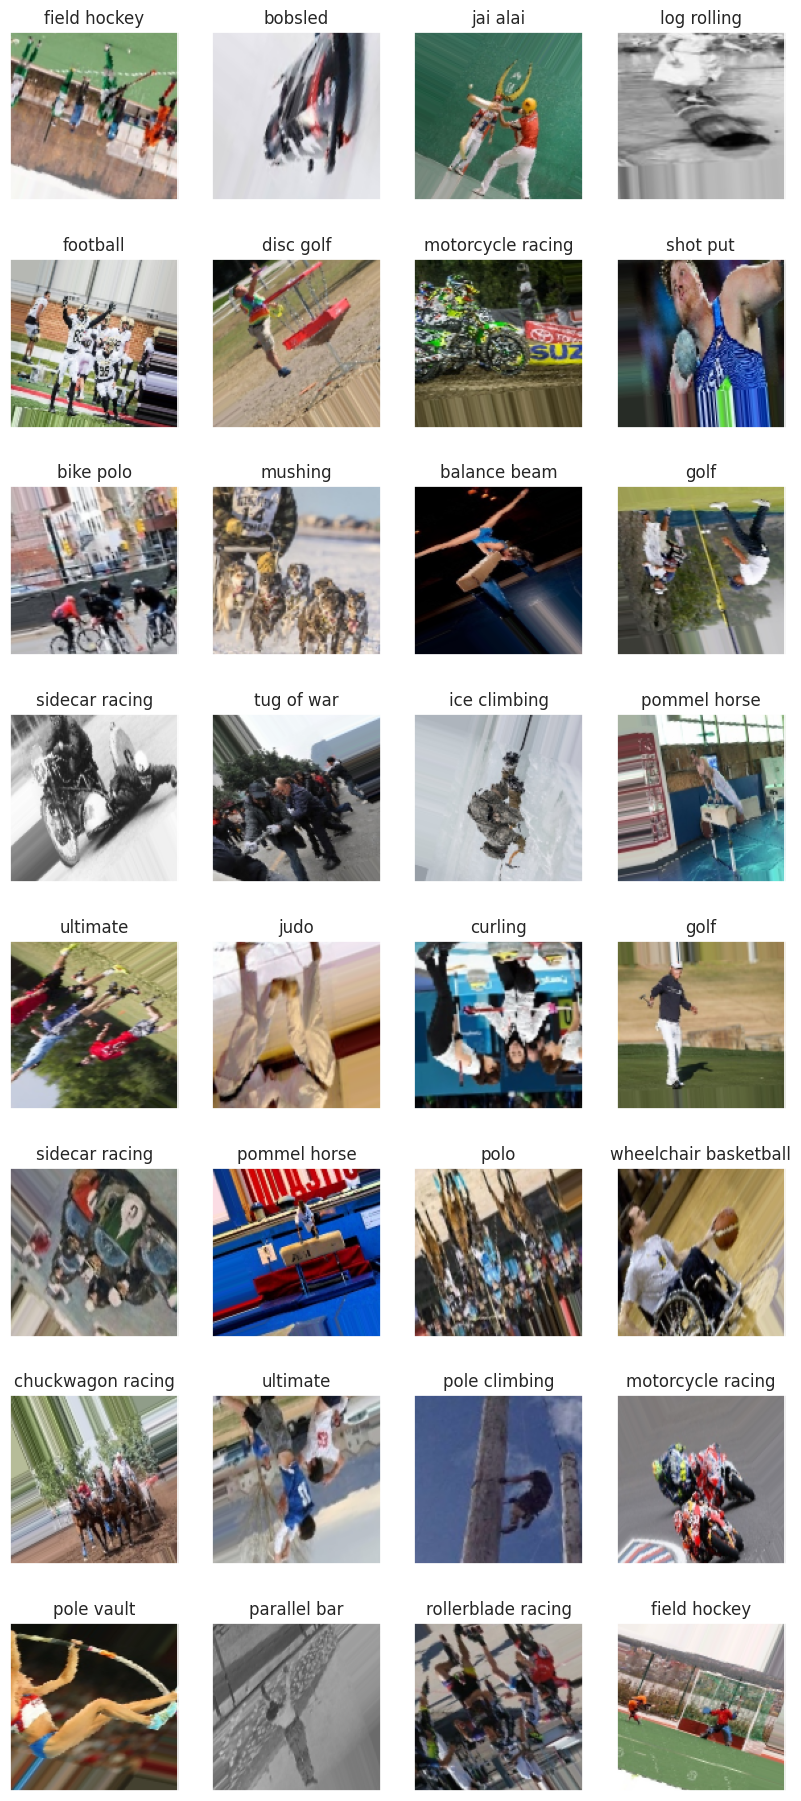

In [7]:
x, y = next(train_data)
y = np.argmax(y, axis=-1)
fig, ax = plt.subplots(8, 4, figsize=(10, 20))
cnt = 0
for a in ax.flatten():
    a.grid(False)
    a.tick_params('both', bottom=False, labelbottom=False, left=False, labelleft=False)
    a.imshow(x[cnt] / 255.0)
    _class = indicies_class[y[cnt]]
    a.set_title(_class)
    cnt += 1
    
fig.subplots_adjust(top=1)

## Model

In [8]:
# Use transfer learning
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=target_size + (3, ), weights='imagenet')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [10]:
def get_base_model(base_model, layer_name):
    base_model.trainable = False
    inputs = base_model.inputs
    outputs = base_model.get_layer(layer_name).output
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
def get_uncompiled_model(base_model, training=True):
    inputs = base_model.inputs
    X = base_model(inputs)
    #X = GlobalMaxPooling2D()(X)
    X = Flatten()(X)
    outputs = Dense(units=100, activation='softmax')(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
# Defining the model
base_model = get_base_model(base_model, 'conv5_block3_out')
model = get_uncompiled_model(base_model)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_4 (Functional)        (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               3276900   
                                                                 
Total params: 26,864,612
Trainable params: 3,276,900
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1_Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
            
    def result(self):
        self.f1.assign(2 * (self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))
        return self.f1
    
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [24]:
# Compile the model
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
loss = tf.losses.categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', F1_Score()])

In [25]:
class EarlyStop(tf.keras.callbacks.Callback):
    def on_epoch_endn(self, epoch, logs={}):
        if logs.get('f1_score') == 0.9:
            self.model.stop_training = True
            print('Training stopped due to reaching a good f1_score')
        
        val_loss = logs.get('val_loss')
        loss = logs.get('loss')
        
        if val_loss - loss >= loss * 0.35:
            self.model.stop_training = True
            print('Training stopped due to high variance')
        

with tf.device('GPU:0'):
    history = model.fit(train_data, epochs=100, validation_data=valid_data)

Epoch 1/100
422/422 [==============================] - 45s 101ms/step - loss: 4.7125 - accuracy: 0.2135 - f1_score: 0.2158 - val_loss: 3.0436 - val_accuracy: 0.4340 - val_f1_score: 0.4412
Epoch 2/100
422/422 [==============================] - 42s 100ms/step - loss: 3.3358 - accuracy: 0.3750 - f1_score: 0.3786 - val_loss: 2.6300 - val_accuracy: 0.5240 - val_f1_score: 0.5296
Epoch 3/100
422/422 [==============================] - 42s 100ms/step - loss: 3.0076 - accuracy: 0.4361 - f1_score: 0.4474 - val_loss: 2.4411 - val_accuracy: 0.5820 - val_f1_score: 0.5821
Epoch 4/100
422/422 [==============================] - 42s 99ms/step - loss: 2.8255 - accuracy: 0.4650 - f1_score: 0.4775 - val_loss: 2.4859 - val_accuracy: 0.5560 - val_f1_score: 0.5624
Epoch 5/100
422/422 [==============================] - 42s 100ms/step - loss: 2.6543 - accuracy: 0.4924 - f1_score: 0.5008 - val_loss: 2.1823 - val_accuracy: 0.5900 - val_f1_score: 0.6063
Epoch 6/100
422/422 [==============================] - 42s 10

422/422 [==============================] - 42s 99ms/step - loss: 1.6942 - accuracy: 0.7026 - f1_score: 0.7090 - val_loss: 2.0944 - val_accuracy: 0.7160 - val_f1_score: 0.7144
Epoch 45/100
422/422 [==============================] - 42s 99ms/step - loss: 1.6545 - accuracy: 0.7090 - f1_score: 0.7141 - val_loss: 2.0168 - val_accuracy: 0.7300 - val_f1_score: 0.7354
Epoch 46/100
422/422 [==============================] - 42s 99ms/step - loss: 1.6182 - accuracy: 0.7137 - f1_score: 0.7189 - val_loss: 2.1978 - val_accuracy: 0.7320 - val_f1_score: 0.7300
Epoch 47/100
422/422 [==============================] - 42s 99ms/step - loss: 1.6335 - accuracy: 0.7079 - f1_score: 0.7141 - val_loss: 2.0825 - val_accuracy: 0.7240 - val_f1_score: 0.7306
Epoch 48/100
422/422 [==============================] - 42s 100ms/step - loss: 1.6196 - accuracy: 0.7104 - f1_score: 0.7167 - val_loss: 2.1053 - val_accuracy: 0.7240 - val_f1_score: 0.7210
Epoch 49/100
422/422 [==============================] - 42s 100ms/step -

422/422 [==============================] - 42s 99ms/step - loss: 1.4775 - accuracy: 0.7495 - f1_score: 0.7541 - val_loss: 2.3224 - val_accuracy: 0.7600 - val_f1_score: 0.7601
Epoch 88/100
422/422 [==============================] - 42s 99ms/step - loss: 1.4844 - accuracy: 0.7547 - f1_score: 0.7587 - val_loss: 2.3899 - val_accuracy: 0.7360 - val_f1_score: 0.7392
Epoch 89/100
422/422 [==============================] - 42s 99ms/step - loss: 1.5274 - accuracy: 0.7519 - f1_score: 0.7555 - val_loss: 2.3593 - val_accuracy: 0.7480 - val_f1_score: 0.7518
Epoch 90/100
422/422 [==============================] - 42s 99ms/step - loss: 1.5501 - accuracy: 0.7477 - f1_score: 0.7524 - val_loss: 2.5289 - val_accuracy: 0.7360 - val_f1_score: 0.7404
Epoch 91/100
422/422 [==============================] - 42s 100ms/step - loss: 1.4346 - accuracy: 0.7620 - f1_score: 0.7654 - val_loss: 2.3847 - val_accuracy: 0.7360 - val_f1_score: 0.7377
Epoch 92/100
422/422 [==============================] - 42s 99ms/step - 

## Evaluation on training

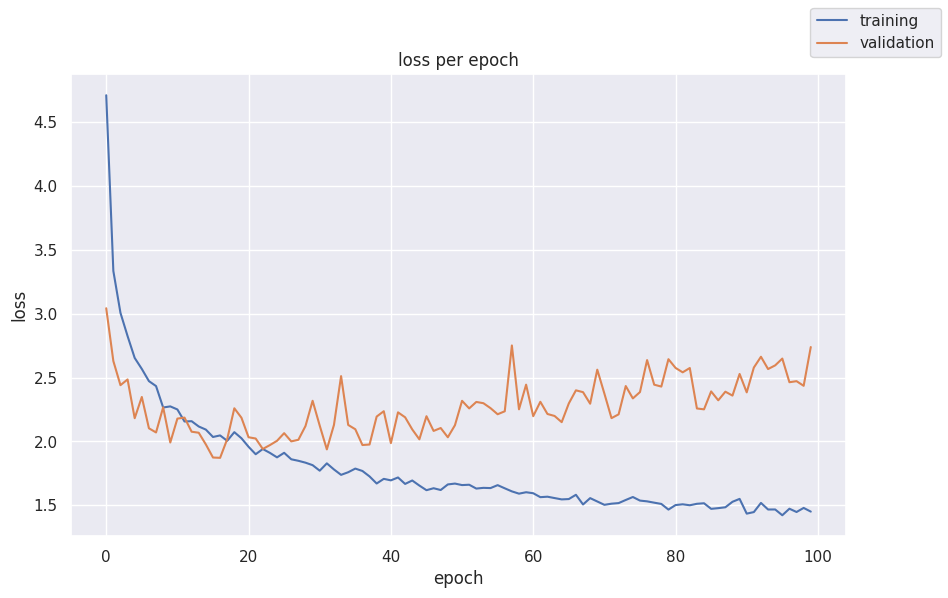

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.legend();

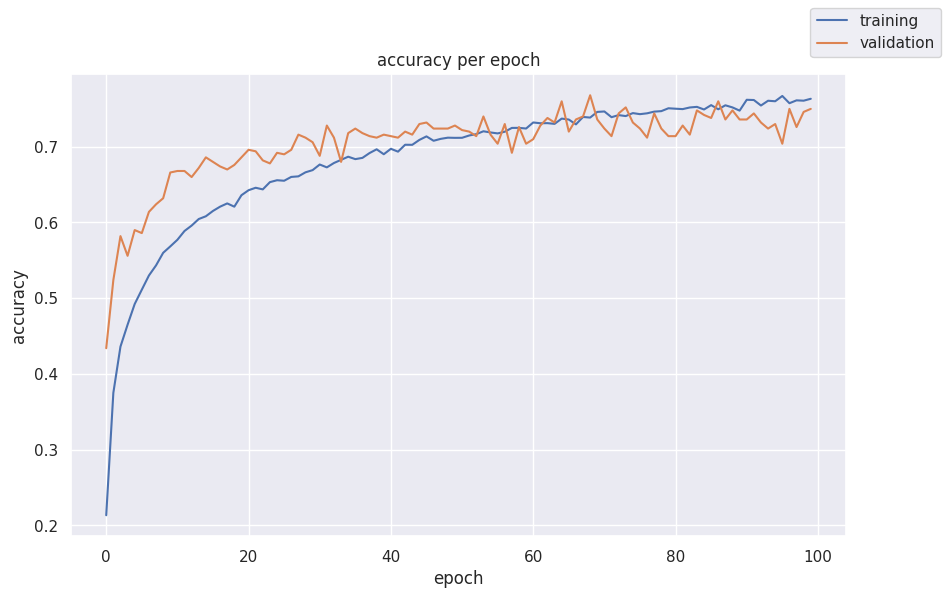

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['accuracy'], label='training')
ax.plot(history.epoch, history.history['val_accuracy'], label='validation')
ax.set_title('accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.legend();

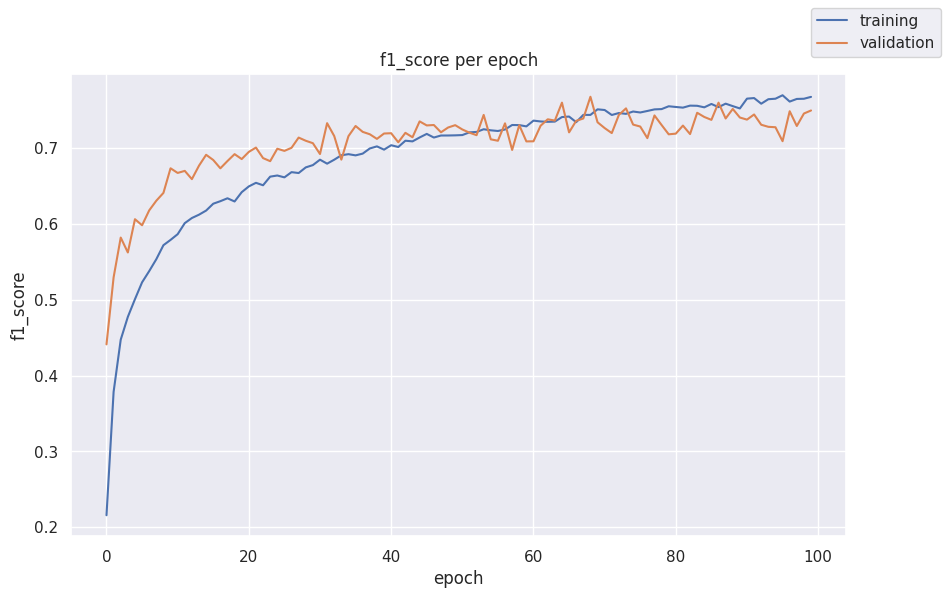

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['f1_score'], label='training')
ax.plot(history.epoch, history.history['val_f1_score'], label='validation')
ax.set_title('f1_score per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('f1_score')
fig.legend();

In [29]:
y_true = np.array([0 for _ in range(valid_data.n)])
y_pred = np.array([0 for _ in range(valid_data.n)])
cnt = 0
for x, y in valid_data:
    y_true[cnt : cnt + y.shape[0]] = np.argmax(y, axis=-1)
    y_pred[cnt : cnt + y.shape[0]] = np.argmax(model.predict(x, verbose=0), axis=-1)
    cnt += y.shape[0]
    print(f'\r{cnt}', end='')
    if cnt >= valid_data.n: break

500

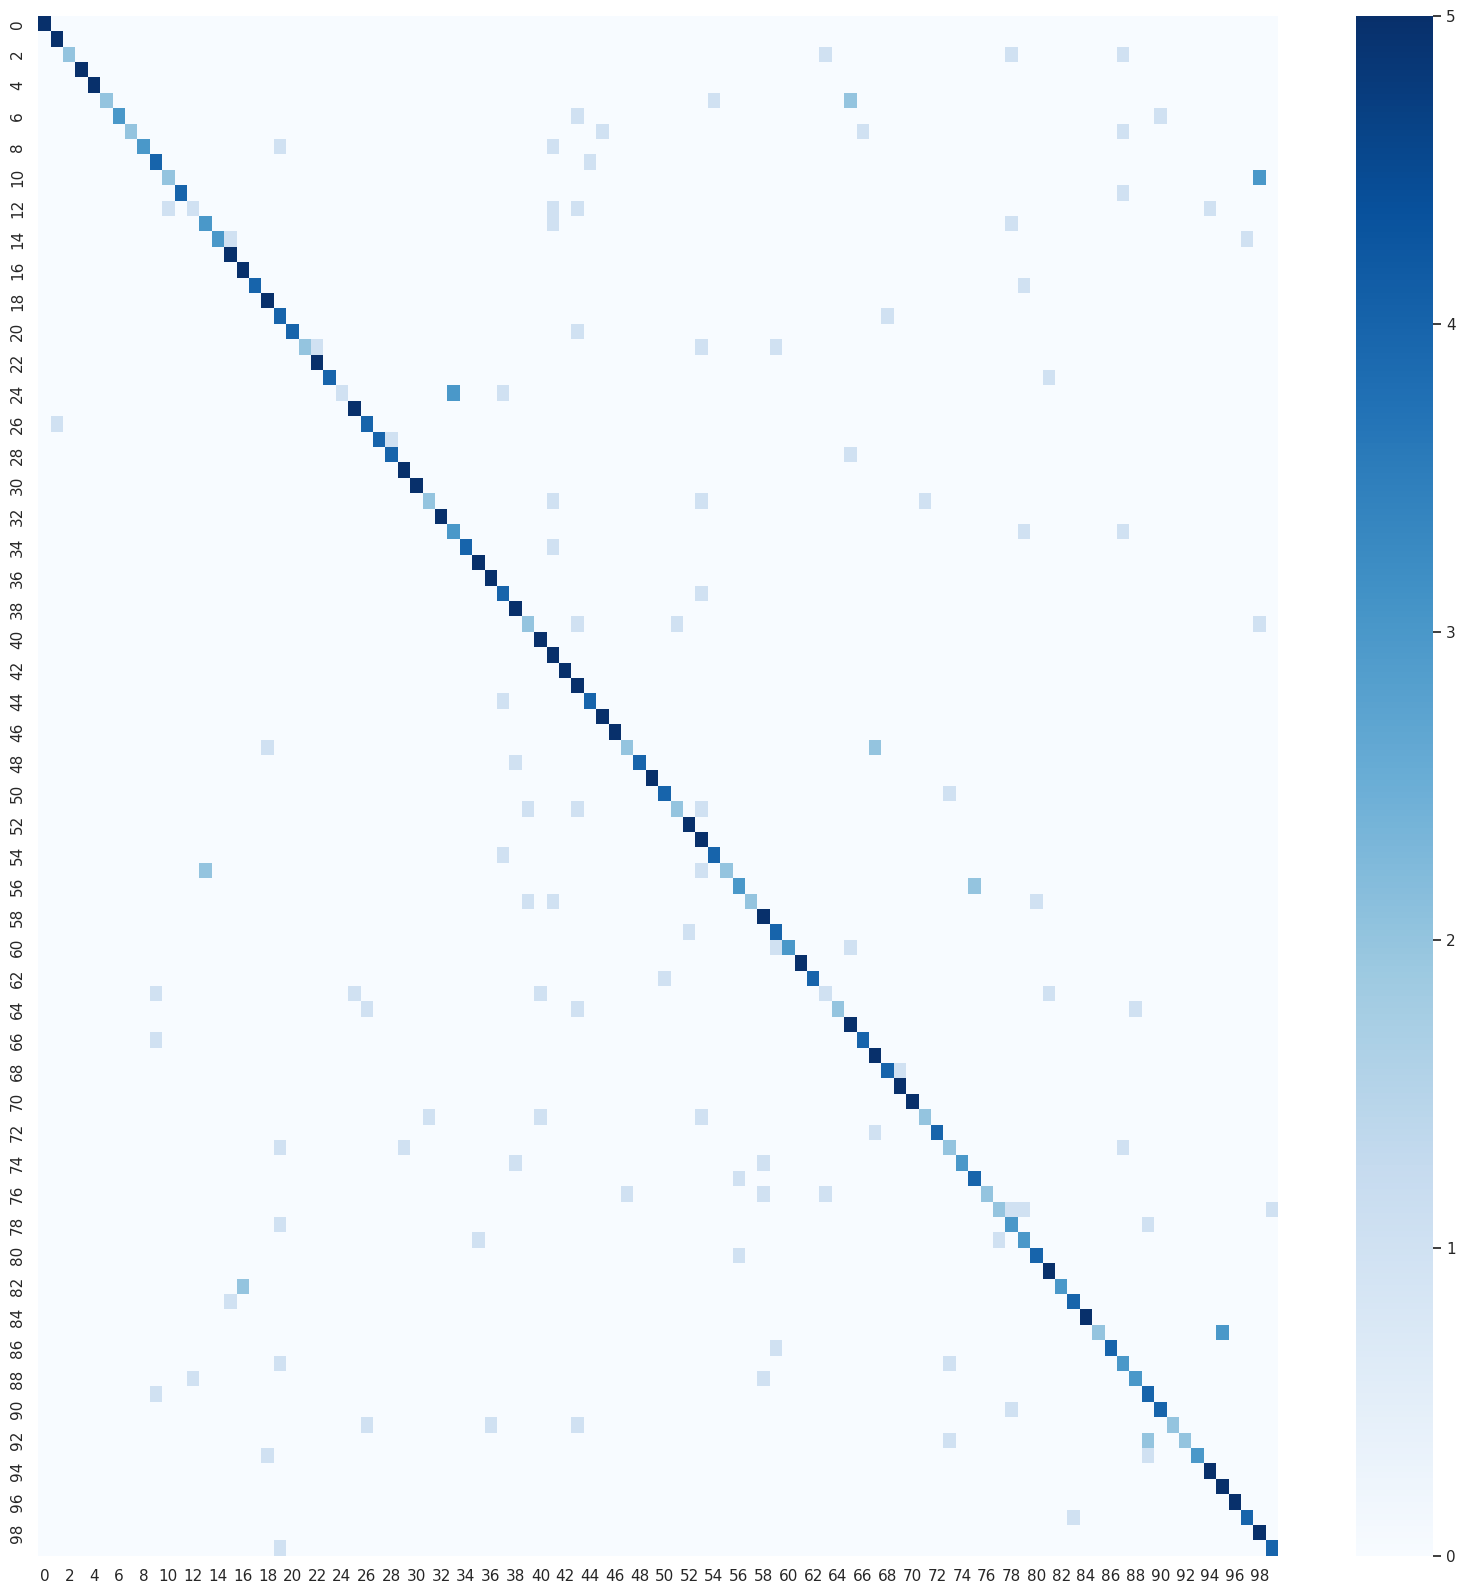

In [30]:
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, cmap='Blues')

In [31]:
report = classification_report(y_true, y_pred, zero_division=True)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.40      0.57         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.40      0.57         5
           6       1.00      0.60      0.75         5
           7       1.00      0.40      0.57         5
           8       1.00      0.60      0.75         5
           9       0.57      0.80      0.67         5
          10       0.67      0.40      0.50         5
          11       1.00      0.80      0.89         5
          12       0.50      0.20      0.29         5
          13       0.60      0.60      0.60         5
          14       1.00      0.60      0.75         5
          15       0.71      1.00      0.83         5
          16       0.71      1.00      0.83         5
          17       1.00    

# Note
Seems like something is wrong with the choice of normalization. And also accuracy for both validation and training is somewhat the same. So the model above has the problem of underfitting.

To address these problems
- Choose more complex model
- Define a proper nomalization

Bugs:
- Early stop callback does not work properly